In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import matplotlib.pyplot as plt
import seaborn as sns

from cloudpickle import dump, load

from feature_engine.datetime import DatetimeFeatures

from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# skforecast

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

from skforecast.model_selection_multiseries import (
    grid_search_forecaster_multiseries,
    random_search_forecaster_multiseries,
    backtesting_forecaster_multiseries,
)

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

from darts import TimeSeries
from darts.models import (
    LightGBMModel,
    XGBModel,
    VARIMA,
    RNNModel,
)

from darts.metrics import (
    smape, mape, mae, mse,
)
from darts.dataprocessing.transformers import Scaler, InvertibleMapper

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

torch.distributed.nn.jit.instantiator INFO  Created a temporary directory at /tmp/tmpukoktqnp
torch.distributed.nn.jit.instantiator INFO  Writing /tmp/tmpukoktqnp/_remote_module_non_scriptable.py


In [2]:
# define helper function to add time-related features

In [44]:
def add_time_features(ride_counts, time_col):
    """add a bunch of useful time-related features"""

    season_month = {12:'Winter', 1:'Winter', 2:'Winter',
                    3:'Spring', 4:'Spring', 5:'Spring',
                    6:'Summer', 7:'Summer', 8:'Summer',
                    9:'Autumn', 10:'Autumn', 11:'Autumn'}

    ride_counts['date'] = ride_counts.loc[:, time_col].dt.date

    dtfs = DatetimeFeatures(
                variables=time_col,
                features_to_extract=["year", "quarter", "month",
                                     "hour", "day_of_week", "weekend"],
                drop_original=False,
    )
    ride_counts = dtfs.fit_transform(ride_counts)
    ride_counts.columns = ride_counts.columns.str.removeprefix('time_')
    ride_counts.loc[:, 'season'] = ride_counts['month'].map(season_month)

    holidays = calendar().holidays(start=ride_counts[time_col].min(), end=ride_counts[time_col].max())
    ride_counts['is_holiday'] = pd.to_datetime(ride_counts.loc[:, 'date']).isin(holidays)
    ride_counts['is_workday'] = ~(ride_counts['weekend'] | ride_counts['is_holiday'])

    return ride_counts

### Get data sources

In [45]:
weather_data = pd.read_csv("data/DCweather_clean.csv",
                      parse_dates=['datetime'],
                      index_col='datetime')

In [56]:
train_data = pd.read_csv("data/train_data.csv", parse_dates=['time'])
test_data = pd.read_csv("data/test_data.csv", parse_dates=['time'])

In [57]:
all_data = pd.concat([train_data, test_data])

In [58]:
# define training, validation (and test splits)
# dataset starts 2021-03-01, ends 2023-06-30
# keep June 2023 as final test set, Mar - May 2023 as validation set
end_train = '2023-02-28 23:59:00'
end_val = '2023-05-31 23:59:00'
SAMPLES_PER_DAY = 24

In [59]:
#rule = "2H"
#SAMPLES_PER_DAY = 12
#train_data = train_data.resample(rule, on='time').sum().reset_index()
#test_data = test_data.resample(rule, on='time').sum().reset_index()
#weather_data = weather_data.asfreq(rule)

In [60]:
train_data = add_time_features(train_data, 'time').set_index('time')
test_data = add_time_features(test_data, 'time').set_index('time')
all_data = add_time_features(all_data, 'time').set_index('time')

In [61]:
train_data = train_data.join(weather_data).asfreq("H").ffill()
test_data = test_data.join(weather_data).asfreq("H").ffill()
all_data = all_data.join(weather_data).asfreq("H").ffill()

define exogenous variables and actual data columns

In [62]:
clus_columns = train_data.columns[train_data.columns.str.contains("clus")]

exog_cols = ['year', 'month', 'season', 'hour', 'is_workday', 'is_holiday', 'rush_hour']
#exog_cols = ['year', 'month', 'hour', 'is_workday', 'is_holiday']

def define_exog(data, data_cols, exog_cols):
    exog = data.drop(data_cols, axis=1)
    exog.drop(["date", "quarter", "feelslike", "visibility"], axis=1, inplace=True)
    exog[['year', 'day_of_week', 'weekend']] = exog[['year', 'day_of_week', 'weekend']].astype("category")
    exog['rush_hour'] = ((exog['hour'] > 5) & (exog['hour'] <= 9)) | ((exog['hour'] >= 16) & (exog['hour'] < 20))
    exog['condition'].replace({'rainy':0, 'cloudy':1, 'clear':2}, inplace=True)
    exog['season'].replace({'Winter':0, 'Autumn':1, 'Spring':1, 'Summer':2}, inplace=True)
    exog = exog.loc[:, exog_cols]
    return exog

exog_train = define_exog(train_data, clus_columns, exog_cols)
exog_test = define_exog(test_data, clus_columns, exog_cols)
exog_all = define_exog(all_data, clus_columns, exog_cols)

train_data = train_data.loc[:, clus_columns]
test_data = test_data.loc[:, clus_columns]
all_data = all_data.loc[:, clus_columns]

### Multivariate forecasting using DARTS

Train first using training + validation set, and optuna hyperparameter optimization

In [63]:
train_data_ts = train_data.sample(n=5, axis='columns', random_state=44)
test_data_ts = test_data.sample(n=5, axis='columns', random_state=44)

train_ts = TimeSeries.from_dataframe(train_data_ts.loc[:end_train, :])
val_ts = TimeSeries.from_series(train_data_ts.loc[end_train:end_val, :])
test_ts = TimeSeries.from_series(test_data_ts)

exog_all_ts = TimeSeries.from_dataframe(exog_all)
exog_train_ts = TimeSeries.from_dataframe(exog_train.loc[:end_train, :])
exog_val_ts = TimeSeries.from_dataframe(exog_train.loc[end_train:end_val, :])
exog_test_ts = TimeSeries.from_dataframe(exog_test)

encoders = {
    'cyclic': {'future': ['month', 'hour']},
    'datetime_attribute': {'future': ['year']},
}

In [29]:
logmapper = InvertibleMapper(
    fn=lambda x: np.log(x+1),
    inverse_fn=lambda x: np.exp(x)-1,
)

In [ ]:
# optuna objective function
def objective_XGB(trial):

    # set input_chunk_length, between 5 and 14 days
    #days_in = trial.suggest_int("days_in", 5, 14)
    #in_len = days_in * 24 # 24H in a day

    # set out_len, between 1 and 14 days
    #days_out = trial.suggest_int("days_out", 1, 14)
    days_out = 14
    out_len = days_out * SAMPLES_PER_DAY

    # Other hyperparameters

    n_estimators = trial.suggest_int("n_estimators", 10, 50)
    max_depth = trial.suggest_int("max_depth", 5, 25)
    #lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)

    # build and fit XGB model
    model = XGBModel(
        lags=1,
        output_chunk_length=out_len,
        add_encoders=encoders,
        lags_future_covariates=[0],
        **{"n_estimators": n_estimators, "max_depth": max_depth},
    )

    model.fit(
        train_ts,
        future_covariates=exog_train_ts,
        max_samples_per_ts=SAMPLES_PER_DAY*100,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(
        n=len(val_ts),
        future_covariates=exog_val_ts,
    )

    #errors = smape(val_ts, preds, n_jobs=-1, verbose=True)
    errors = mae(val_ts, preds)
    error_val = np.mean(errors)

    return error_val if error_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Duration: {trial.duration}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")
study.optimize(objective_XGB, timeout=60*120, callbacks=[print_callback])

Current value: 6.570285785844814, Current params: {'n_estimators': 42, 'max_depth': 16}
Duration: 0:11:18.698687
Best value: 6.570285785844814, Best params: {'n_estimators': 42, 'max_depth': 16}
Current value: 6.754701367092068, Current params: {'n_estimators': 46, 'max_depth': 14}
Duration: 0:09:33.332790
Best value: 6.570285785844814, Best params: {'n_estimators': 42, 'max_depth': 16}
Current value: 6.57022712052777, Current params: {'n_estimators': 48, 'max_depth': 16}
Duration: 0:11:05.230256
Best value: 6.57022712052777, Best params: {'n_estimators': 48, 'max_depth': 16}
Current value: 6.710326828809764, Current params: {'n_estimators': 10, 'max_depth': 23}
Duration: 0:03:02.950930
Best value: 6.57022712052777, Best params: {'n_estimators': 48, 'max_depth': 16}
Current value: 6.6560984239825824, Current params: {'n_estimators': 43, 'max_depth': 22}
Duration: 0:13:49.519042
Best value: 6.57022712052777, Best params: {'n_estimators': 48, 'max_depth': 16}
Current value: 6.68745520349

In [ ]:
df_opts = study.trials_dataframe()
assert isinstance(df_opts, pd.DataFrame)
df_opts

### retrain using best parameters on training+validation

In [37]:
study.best_params

{'n_estimators': 23, 'max_depth': 5}

In [87]:
with open('model_artefacts/xgb_6clus_bestparams.pkl','rb') as file:
    study = load(file)

In [38]:
# redefine train and test using all clusters
# also make train and exog_train using training and validation periods
train_ts = TimeSeries.from_dataframe(train_data.loc[:end_val, :])
exog_ts = TimeSeries.from_dataframe(exog_data.loc[:end_val, :])
test_ts = TimeSeries.from_series(test_data)

In [45]:
darts_xgb = XGBModel(
    lags=1,
    output_chunk_length=14*SAMPLES_PER_DAY,
    add_encoders=encoders,
    lags_future_covariates=[0],
    **study.best_params,
)
darts_xgb.fit(
    train_ts,
    future_covariates=exog_ts,
    max_samples_per_ts=SAMPLES_PER_DAY*100,
)

XGBModel(lags=1, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=336, add_encoders={'cyclic': {'future': ['month', 'hour']}, 'datetime_attribute': {'future': ['year']}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, n_estimators=23, max_depth=5)

In [46]:
#with open('model_artefacts/darts_xgb_6clus.pkl','rb') as file:
#    darts_xgb = load(file)

In [49]:
predictions = darts_xgb.predict(
                series=train_ts,
                n=len(test_ts),
                future_covariates=exog_test_ts,
)

matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
matplotlib.legend WARNING No artists with labels found to put in legend.  Note that a

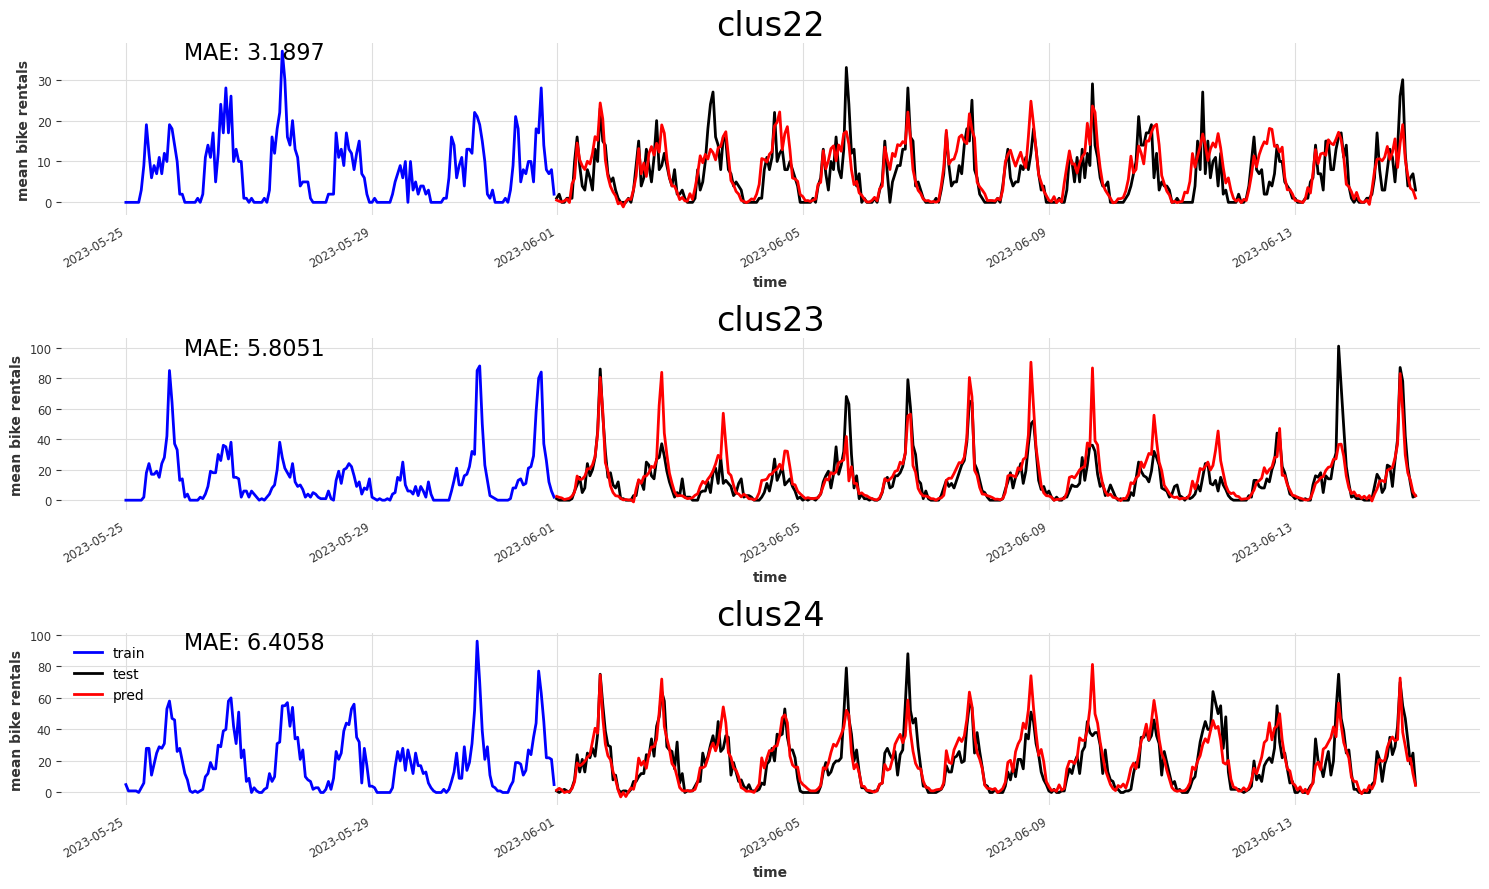

In [107]:
#predictions_rescaled = logmapper.inverse_transform(predictions)

# 4, 12, 20, 22, 23/24, 27 (evening rush hour)

clus = [22, 23, 24]

fig, axs = plt.subplots(len(clus), 1, figsize=(15, 9))

for i, c in enumerate(clus):
    clus_label = f'clus{c}'

    train_ts[clus_label][-24*7:].plot(color="b", label="train", ax=axs[i])
    test_ts[clus_label][:24*14].plot(color="k", label="test", ax=axs[i])
    predictions[clus_label][:24*14].plot(color="r", label='pred', ax=axs[i])
    axs[i].set_ylabel('mean bike rentals')
    mae_text = f'MAE: {np.round(mae(predictions[clus_label],test_ts[clus_label]),4)}'
    xlims=axs[i].get_xlim()
    ylims=axs[i].get_ylim()
    axs[i].annotate(mae_text, xy=(xlims[0]+2, ylims[1]*0.9), fontsize=16)
    axs[i].set_title(clus_label, fontsize=24)
fig.tight_layout()
plt.savefig(f"figs/clus22_24_test_pred_XGB.png", format='png', transparent=True, bbox_inches='tight')
plt.show()

In [108]:
darts_xgb.save("model_artefacts/darts_xgb_5clus.pkl")

In [40]:
with open('model_artefacts/xgb_5clus_bestparams.pkl','wb') as file:
    dump(study, file)

In [40]:
with open('model_artefacts/xgb_5clus_bestparams.pkl','rb') as file:
    study= load(file)

In [42]:
study.best_params

{'n_estimators': 23, 'max_depth': 5}

### retrain again with full data (training+test set, for deployment)

In [ ]:
# redefine train and test using all clusters
# also make train and exog_train using training and validation periods
data_ts = TimeSeries.from_dataframe(all_data)

darts_xgb = XGBModel(
    lags=1,
    output_chunk_length=14*SAMPLES_PER_DAY,
    add_encoders=encoders,
    lags_future_covariates=[0],
    **study.best_params,
)
darts_xgb.fit(
    data_ts,
    future_covariates=exog_all_ts,
    max_samples_per_ts=SAMPLES_PER_DAY*100,
)

XGBModel(lags=1, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=336, add_encoders={'cyclic': {'future': ['month', 'hour']}, 'datetime_attribute': {'future': ['year']}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, n_estimators=23, max_depth=5)

In [69]:
darts_xgb.save("model_artefacts/darts_xgb_clus_alldata.pkl")

In [70]:
with open('model_artefacts/darts_xgb_clus_alldata.pkl','wb') as file:
    dump(darts_xgb, file)

### VARIMA

In [ ]:
darts_varima = VARIMA(p=12, d=0, q=0, trend="n")

darts_varima.fit(
    train_ts,
    #future_covariates=exog_ts,
)


### RNN

In [ ]:
transformer = Scaler()
train_ts_scaled = Scaler().fit_transform(train_ts)
val_ts_scaled = Scaler().fit_transform(val_ts)

lstm_model = RNNModel(
    model="LSTM",
    input_chunk_length=24*5,
    output_chunk_length=24,
    training_length=24*5*5,
    hidden_dim=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    model_name="rides_clus_RNN",
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
)
lstm_model.fit(
    train_ts_scaled,
    future_covariates=exog_ts,
    val_series=val_ts_scaled,
    val_future_covariates=exog_val,
    verbose=True,
)

In [ ]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=exog_all)
    fig, axs = plt.subplots(3, 1, figsize=(12, 5))
    for i, ax in enumerate(axs):
        val_ts_scaled[f'clus{i}'][:24*14].plot(label="actual", linewidth=1.5, ax=ax)
        pred_series[f'clus{i}'][:24*14].plot(label="forecast", linewidth=1.5, ax=ax)
    plt.title("MAE: {:.2f}%".format(mae(pred_series, val_ts_scaled)))

eval_model(lstm_model)

### Forecasting on individual clusters 2. skforecast regression models

In [21]:
data = pd.concat([train_data, test_data])
data = data.asfreq("H").ffill() # couple of nans in weather, forward fill seems reasonable

In [25]:
# Split train-validation-test
# ==============================================================================
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_val, :]
data_test  = data.loc[end_val:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2021-03-01 00:00:00 --- 2022-12-31 23:00:00  (n=16104)
Dates validation : 2023-01-01 00:00:00 --- 2023-05-31 23:00:00  (n=3624)
Dates test       : 2023-06-01 00:00:00 --- 2023-06-30 23:00:00  (n=720)


### Multiseries forecasting

In [ ]:
models = [RandomForestRegressor(random_state=123),
          XGBRegressor(random_state=123),
          HistGradientBoostingRegressor(random_state=123),
          LGBMRegressor(random_state=123)]

# Hyperparameter to search for each model
param_grids = {'RandomForestRegressor': {'n_estimators': [20, 50], 'max_depth': [5, 10, 15]},
               'XGBRegressor': {'n_estimators': [20, 50], 'max_depth': [5, 10, 15]},
               'HistGradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 1], 'max_depth': [5, 10, 15]},
               'LGBMRegressor': {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [20, 50], 'max_depth': [5, 10, 15]},
               }

metrics = ['mean_squared_error', 'mean_absolute_error']

# Lags used as predictors
lags_grid = [[1, 24, 24*7]]

df_results_ms = pd.DataFrame()
all_ms_forecasters = {}

for i, model in enumerate(models):

    forecaster_ms = ForecasterAutoregMultiSeries(
                        regressor          = model,
                        lags               = 1,  # this is irrelevant, gets overwritten in grid_search below
                        transformer_exog = transformer_exog,
                )
    param_grid = param_grids[list(param_grids)[i]]

    results_grid = grid_search_forecaster_multiseries(
                   forecaster         = forecaster_ms,
                   series             = series_data.loc[:end_val, :],
                   exog               = exog.loc[:end_val, exog_cols],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 24*7*4,
                   refit              = False,
                   metric             = metrics,
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

    # Create a column with model name
    results_grid['model'] = list(param_grids)[i]

    df_results_ms = pd.concat([df_results_ms, results_grid])
    
    # save the forecasters
    all_ms_forecasters[list(param_grids.keys())[i]] = forecaster_ms

df_results_ms = df_results_ms.sort_values(by='mean_absolute_error')

In [35]:
# review df_results,
# plot predictions from best performing model, for each series
best_forecaster = all_ms_forecasters["RandomForestRegressor"]

# Backtesting (cross-validation) on training data, with intervals
# ==============================================================================
metric_ms, predictions_ms = backtesting_forecaster_multiseries(
    forecaster         = best_forecaster,
    series             = series_data.loc[:end_val, :],
    exog               = exog.loc[:end_val, exog_cols],
    steps              = 24*7*2,
    gap = 24*2,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data.loc[:end_train]),
    refit              = False,
    verbose            = True,
    show_progress      = False
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 16104
Number of observations used for backtesting: 2880
    Number of folds: 9
    Number of steps per fold: 336
    Number of steps to exclude from the end of each train set before test (gap): 48
    Last fold only includes 144 observations.

Fold: 0
    Training:   2021-03-01 00:00:00 -- 2022-12-31 23:00:00  (n=16104)
    Validation: 2023-01-03 00:00:00 -- 2023-01-16 23:00:00  (n=336)
Fold: 1
    Training:   2021-03-01 00:00:00 -- 2022-12-31 23:00:00  (n=16104)
    Validation: 2023-01-17 00:00:00 -- 2023-01-30 23:00:00  (n=336)
Fold: 2
    Training:   2021-03-01 00:00:00 -- 2022-12-31 23:00:00  (n=16104)
    Validation: 2023-01-31 00:00:00 -- 2023-02-13 23:00:00  (n=336)
Fold: 3
    Training:   2021-03-01 00:00:00 -- 2022-12-31 23:00:00  (n=16104)
    Validation: 2023-02-14 00:00:00 -- 2023-02-27 23:00:00  (n=336)
Fold: 4
    Training:   2021-03-01 00:00:00 -- 2022-

In [ ]:
# Plot
fig, ax = plt.subplots(len(clus_columns), 1, figsize=(7, 10))
for n, clus in enumerate(clus_columns):
    ax[n].plot(data_val[clus].iloc[:24*7], label='test', color='k', linewidth=1)
    ax[n].plot(predictions_ms[clus].iloc[:24*7], label='predictions', color='r', linewidth=1)
#_ = ax.legend(bbox_to_anchor=(1.02, 1))

### Create MultiVariate Forecasters


In [33]:
xgb_mv_forecaster = ForecasterAutoregMultiVariate(
    regressor = XGBRegressor(random_state=123),
    level = f'clus{cluster}',
    lags = lags,
    steps = steps,
    transformer_series=transformer_y,
    transformer_exog=transformer_exog,
    forecaster_id=f'XGB_mv_forecast_clus{clus}_lag1',
)

lgb_mv_forecaster = ForecasterAutoregMultiVariate(
    regressor = LGBMRegressor(random_state=123),
    level = f'clus{cluster}',
    lags = lags,
    steps = steps,
    transformer_series=transformer_y,
    transformer_exog=transformer_exog,
    forecaster_id=f'LGB_mv_forecast_clus{clus}_lag1',
)

hgb_mv_forecaster = ForecasterAutoregMultiVariate(
    regressor = HistGradientBoostingRegressor(random_state=123),
    level = f'clus{cluster}',
    lags = lags,
    steps = steps,
    transformer_series=transformer_y,
    transformer_exog=transformer_exog,
    forecaster_id=f'HGB_mv_forecast_clus{clus}_lag1',
)

rf_mv_forecaster = ForecasterAutoregMultiVariate(
    regressor = RandomForestRegressor(random_state=123),
    level = f'clus{cluster}',
    lags = lags,
    steps = steps,
    transformer_series=transformer_y,
    transformer_exog=transformer_exog,
    forecaster_id=f'RF_mv_forecast_clus{clus}_lag1',
)

In [40]:
lgb_forecaster = ForecasterAutoregMultiVariate(
                    regressor = LGBMRegressor(random_state=123),
        level = f'clus{cluster}',
        lags = 2,
        steps = 24*7,
        transformer_exog = transformer_exog,
        weight_func = None,
        forecaster_id = f'LGBM_cluster{cluster}_lags2'
    )

LGBM_forecaster.fit(
    series=series,
    exog=exog,
)

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(train['clus0'].iloc[-24*7:], label='clus0')
ax.plot(train['clus2'].iloc[-24*7:], label='clus2')
ax.plot(train['clus34'].iloc[-24*7:], label='clus34')
#ax.plot(train['clus47'].iloc[-24*7:], label='clus47')


In [ ]:
# Lags used as predictors
lags_grid = [1, 2, 3]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}


# Create and forecaster MultiVariate
forecaster = ForecasterAutoregMultiVariate(
                 regressor = RandomForestRegressor(random_state=42),
                 level = 'clus0',
                 lags = 7,
                 steps=24,
                 transformer_series = None,
                 transformer_exog = transformer_exog,
                 weight_func = None
             )

results_grid = grid_search_forecaster_multiseries(
    forecaster=forecaster,
    series=series,
    exog=exog,
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=24,
    metric="mean_absolute_error",
    initial_train_size=len(train),
    fixed_train_size=False,
    refit=False,
    return_best=True,
    show_progress=True,
)